In [1]:
from utilities import *

DATA PRE-PROCESSING

In [2]:
Data = pd.read_csv('Churn.csv')
df =Data.copy()

In [3]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [4]:
# dropping columns rownumber, customerid and surname as they will not add value to the models:
df.drop(['CustomerId','Surname'], axis=1, inplace=True)

Binning the Age column to create a categorical variable. 

In [5]:
# Binning the age column
df['Age'].unique()

# Define bins and labels for the age groups
bins = [18, 30, 40, 50, 60, 93]
labels = ['18-29', '30-39', '40-49', '50-59', '60+']

# Bin the ages
age_groups = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Display the binned ages
age_groups
#adding this to the df
df = df.assign(Age_binned=age_groups)


Binning the creditscore column to create a categorical variable

In [6]:
# binning the creditscore column
# Define bins for credit score ranges
credit_bins = [349, 450, 550, 650, 750, 850]
credit_labels = ['350-449', '450-549', '550-649', '650-749', '750-850']

# Bin the credit scores
credit_score_groups = pd.cut(df['CreditScore'], bins=credit_bins, labels=credit_labels, right=True)

# Display the binned credit scores
credit_score_groups
#adding this to the df
df = df.assign(CreditScore_binned=credit_score_groups)

In [7]:
# dropping the columns RowNumber, Age and CreditScore
data = df.drop(['RowNumber','Age','CreditScore'], axis=1)

In [8]:
# Loop through the columns and convert only object columns to categorical
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Geography           10000 non-null  category
 1   Gender              10000 non-null  category
 2   Tenure              10000 non-null  int64   
 3   Balance             10000 non-null  float64 
 4   NumOfProducts       10000 non-null  int64   
 5   HasCrCard           10000 non-null  int64   
 6   IsActiveMember      10000 non-null  int64   
 7   EstimatedSalary     10000 non-null  float64 
 8   Exited              10000 non-null  int64   
 9   Age_binned          10000 non-null  category
 10  CreditScore_binned  10000 non-null  category
dtypes: category(4), float64(2), int64(5)
memory usage: 586.7 KB


TRAIN -VALIDATION-TEST-SPLIT

In [9]:
# sepearting independent from dependent variables
X = data.drop(['Exited'],axis=1)
Y = data['Exited']

# Splitting the dataset into the Training and Test set.
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify = Y)


# Splitting the Train dataset into the Training and Validation set.
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size = 0.2, random_state = 42,stratify = y_train)


#Printing the shapes.
print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)
print(X_test.shape,y_test.shape)

(6400, 10) (6400,)
(1600, 10) (1600,)
(2000, 10) (2000,)


Dummy variable creation of categorical cariables

In [10]:
# creating dummy variables
X_train = pd.get_dummies(X_train,drop_first = True)
X_valid = pd.get_dummies(X_valid,drop_first = True)
X_test = pd.get_dummies(X_test,drop_first = True)

print(X_train.shape, X_valid.shape, X_test.shape)
X_train.head()
X_train.columns

(6400, 17) (1600, 17) (2000, 17)


Index(['Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Geography_Germany', 'Geography_Spain',
       'Gender_Male', 'Age_binned_30-39', 'Age_binned_40-49',
       'Age_binned_50-59', 'Age_binned_60+', 'CreditScore_binned_450-549',
       'CreditScore_binned_550-649', 'CreditScore_binned_650-749',
       'CreditScore_binned_750-850'],
      dtype='object')

Data normalization 

In [11]:
#Standardizing the numerical variables to zero mean and unit variance.
transformer = StandardScaler()
X_train[['Tenure','Balance','NumOfProducts','EstimatedSalary']] = transformer.fit_transform(X_train[['Tenure','Balance','NumOfProducts','EstimatedSalary']])
X_valid[['Tenure','Balance','NumOfProducts','EstimatedSalary']] = transformer.fit_transform(X_valid[['Tenure','Balance','NumOfProducts','EstimatedSalary']])
X_test[['Tenure','Balance','NumOfProducts','EstimatedSalary']] = transformer.fit_transform(X_test[['Tenure','Balance','NumOfProducts','EstimatedSalary']])

Building base model

The model can make wrong predictions as:
predicting the customer did not leave the bank and the customer actually leaving the bank.
Predicting the customer leaving the bank and the customer actually not leaving the bank.
Predicting the customer not leaving the bank and the customer actually leaving the bank is a more important case.
The company would want recall to be minimized, as the greater the recall the higher the chances of minimizing false negatives.
Hence the metric of importance is RECALL.

Neural Network with SGD Optimizer

In [12]:
# defining the batch size and # epochs upfront as I'll be using the same values for all models
epochs = 25
batch_size = 64

This neural network consists of:
2 hidden layers with 14 and 7 neurons respectively
Relu activation for both hidden layers
SGD as optimizer
sigmoid activation for output layer because it is a binary classification problem.

In [13]:
#Initializing the neural network
model = Sequential()
model.add(Dense(14,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(7,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                252       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 365 (1.43 KB)
Trainable params: 365 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/25
100/100 [==============================] - 0s 2ms/step - loss: 0.7398 - val_loss: 0.6567
Epoch 2/25
100/100 [==============================] - 0s 949us/step - loss: 0.6149 - val_loss: 0.5869
Epoch 3/25
100/100 [==============================] - 0s 1ms/step - loss: 0.5672 - val_loss: 0.5533
Epoch 4/25
100/100 [==============================] - 0s 1ms/step - loss: 0.5423 - val_loss: 0.5347
Epoch 5/25
100/100 [==============================] - 0s 661us/step - loss: 0.5278 - val_loss: 0.5235
Epoch 6/25
100/100 [==============================] - 0s 637us/step - loss: 0.5188 - val_loss: 0.5164
Epoch 7/25
100/100 [==============================] - 0s 676us/step - loss: 0.5130 - val_loss: 0.5117
Epoch 8/25
100/100 [==============================] - 0s 637us/step - loss: 0.5091 - val_loss: 0.5085
Epoch 9/25
100/100 [==============================] - 0s 652us/step - loss: 0.5063 - val_loss: 0.5062
Epoch 10/25
100/100 [==============================] - 0s 630us/step - loss: 0.5043 - va

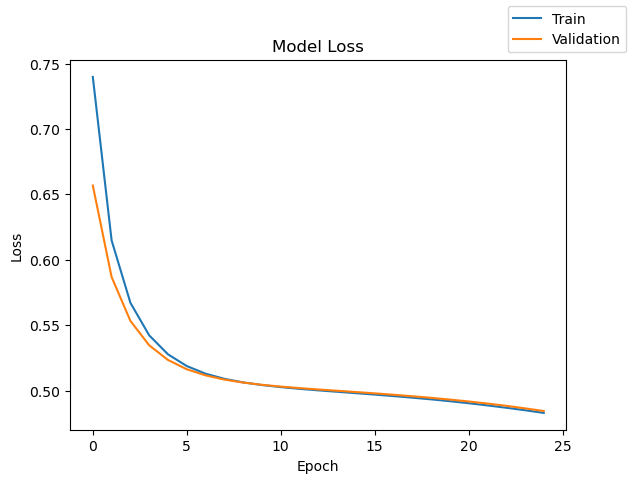

In [14]:
optimizer = tf.keras.optimizers.SGD()    # defining SGD as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs)
end=time.time()

print("Time taken in seconds ",end-start)

plot(history,'loss')



In [15]:
# Performance check
model1_train_performance = model_performance_classification(model,X_train,y_train)
print(model1_train_performance)

model1_valid_performance = model_performance_classification(model,X_valid,y_valid)
print(model1_valid_performance)



200/200 [==============================] - 0s 408us/step
   Accuracy    Recall  Precision  F1 Score
0  0.800781  0.800781    0.84065  0.716581
50/50 [==============================] - 0s 370us/step
   Accuracy    Recall  Precision  F1 Score
0  0.800625  0.800625    0.84055   0.71622


The difference between train recall and validation score is less than ~1% which is a consistent performance of the model between the training and validation dataset.
A score of above 80% for both training and validation dataset is good but has the potential to perform better with some other model improvements.

Model Improvements:

Keeping the SGD optimizer and adding momentum to check whether it is accelerating the process.

Neural Network with SGD Optimizer + momentum

In [16]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [17]:
#Initializing the neural network
model = Sequential()
model.add(Dense(14,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(7,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                252       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 365 (1.43 KB)
Trainable params: 365 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/25
100/100 [==============================] - 0s 2ms/step - loss: 0.4928 - val_loss: 0.4560
Epoch 2/25
100/100 [==============================] - 0s 689us/step - loss: 0.4232 - val_loss: 0.4176
Epoch 3/25
100/100 [==============================] - 0s 682us/step - loss: 0.3934 - val_loss: 0.3946
Epoch 4/25
100/100 [==============================] - 0s 682us/step - loss: 0.3785 - val_loss: 0.3851
Epoch 5/25
100/100 [==============================] - 0s 672us/step - loss: 0.3698 - val_loss: 0.3808
Epoch 6/25
100/100 [==============================] - 0s 670us/step - loss: 0.3646 - val_loss: 0.3737
Epoch 7/25
100/100 [==============================] - 0s 670us/step - loss: 0.3608 - val_loss: 0.3769
Epoch 8/25
100/100 [==============================] - 0s 673us/step - loss: 0.3586 - val_loss: 0.3673
Epoch 9/25
100/100 [==============================] - 0s 669us/step - loss: 0.3555 - val_loss: 0.3773
Epoch 10/25
100/100 [==============================] - 0s 681us/step - loss: 0.3556 

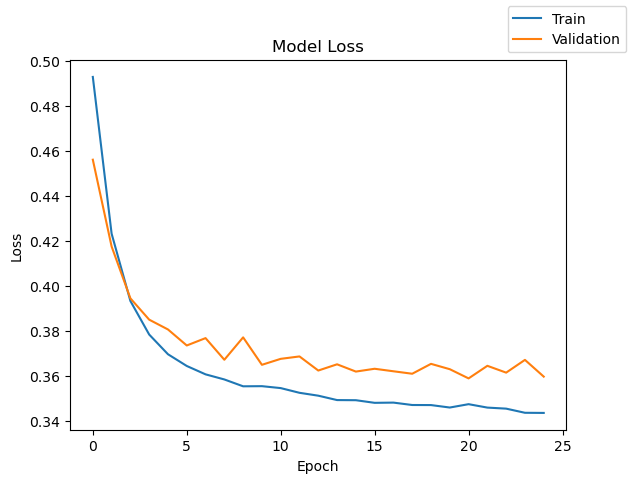

In [18]:
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)    # defining SGD as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs)
end=time.time()

print("Time taken in seconds ",end-start)

plot(history,'loss')


In [19]:
# Performance check
model2_train_performance = model_performance_classification(model,X_train,y_train)
print(model1_train_performance)

model2_valid_performance = model_performance_classification(model,X_valid,y_valid)
print(model2_valid_performance)



200/200 [==============================] - 0s 429us/step
   Accuracy    Recall  Precision  F1 Score
0  0.800781  0.800781    0.84065  0.716581
50/50 [==============================] - 0s 376us/step
   Accuracy  Recall  Precision  F1 Score
0    0.8525  0.8525    0.84096  0.839182



The recall on the validation dataset (~84.6%) is better than that of the training datase(~82.3%), which is good as it dincates it has the potential to perfrom well on unseen data. 
A score of above 80% for both training and validation dataset is good but has the potential to perform better with some other model improvements.

Neural Network with SGD Optimizer + momentum + early stopping 

In [21]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [22]:
#adding earlystopping callback
es= keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=15,verbose=0, mode='min', restore_best_weights= True)

In [23]:
#Initializing the neural network
model = Sequential()
model.add(Dense(14,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(7,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                252       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 365 (1.43 KB)
Trainable params: 365 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/25
100/100 [==============================] - 0s 2ms/step - loss: 0.5111 - val_loss: 0.4800
Epoch 2/25
100/100 [==============================] - 0s 696us/step - loss: 0.4501 - val_loss: 0.4464
Epoch 3/25
100/100 [==============================] - 0s 1ms/step - loss: 0.4127 - val_loss: 0.4133
Epoch 4/25
100/100 [==============================] - 0s 699us/step - loss: 0.3860 - val_loss: 0.3935
Epoch 5/25
100/100 [==============================] - 0s 670us/step - loss: 0.3709 - val_loss: 0.3865
Epoch 6/25
100/100 [==============================] - 0s 665us/step - loss: 0.3632 - val_loss: 0.3776
Epoch 7/25
100/100 [==============================] - 0s 678us/step - loss: 0.3575 - val_loss: 0.3784
Epoch 8/25
100/100 [==============================] - 0s 670us/step - loss: 0.3549 - val_loss: 0.3711
Epoch 9/25
100/100 [==============================] - 0s 667us/step - loss: 0.3510 - val_loss: 0.3801
Epoch 10/25
100/100 [==============================] - 0s 669us/step - loss: 0.3515 - 

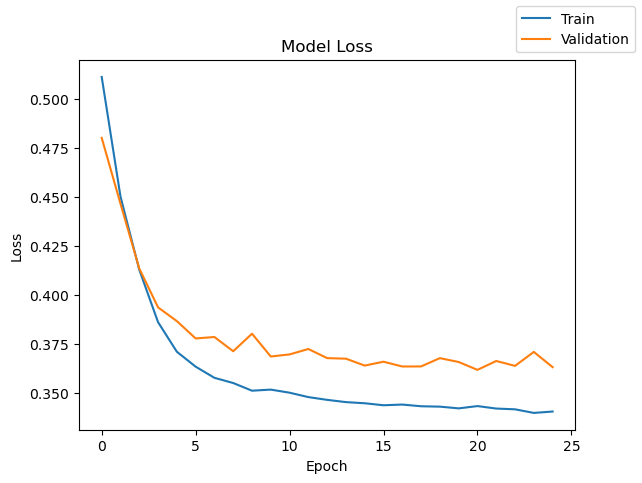

In [24]:
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)    # defining SGD as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs, callbacks=[es])
end=time.time()

print("Time taken in seconds ",end-start)

plot(history,'loss')

In [25]:
# Performance check
model3_train_performance = model_performance_classification(model,X_train,y_train)
print(model3_train_performance)

model3_valid_performance = model_performance_classification(model,X_valid,y_valid)
print(model3_valid_performance)


200/200 [==============================] - 0s 601us/step
   Accuracy    Recall  Precision  F1 Score
0  0.858125  0.858125   0.847875  0.846532
50/50 [==============================] - 0s 456us/step
   Accuracy   Recall  Precision  F1 Score
0   0.85375  0.85375   0.842612  0.839679



Adding early stopping increased the recall for both training and validation set to ~85%. The fact that the difference between both sets is small indicates there is not a problem of overfitting. 

The next model to be constructed, will keep the SGD optimizer, momentum, and early stopping and introduce weight (he) initalization and observe whether there is an increase in performance of recall.

Neural Network with SGD Optimizer + momentum + early stopping + weight initalization

In [26]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                252       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 365 (1.43 KB)
Trainable params: 365 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/25
100/100 [==============================] - 0s 2ms/step - loss: 0.5287 - val_loss: 0.4999
Epoch 2/25
100/100 [==============================] - 0s 694us/step - loss: 0.4752 - val_loss: 0.4754
Epoch 3/25
100/100 [==============================] - 0s 685us/step - loss: 0.4489 - val_loss: 0.4550
Epoch 4/25
100/100 [==============================] - 0s 676us/step - loss: 0.4271 - val_loss: 0.4346
Epoch 5/25
100/100 [==============================] - 0s 671us/step - loss: 0.4084 - val_loss: 0.4156
Epoch 6/25
100/100 [==============================] - 0s 671us/step - loss: 0.3917 - val_loss: 0.4021
Epoch 7/25
100/100 [==============================] - 0s 686us/step - loss: 0.3787 - val_loss: 0.3926
Epoch 8/25
100/100 [==============================] - 0s 677us/step - loss: 0.3698 - val_loss: 0.3861
Epoch 9/25
100/100 [==============================] - 0s 675us/step - loss: 0.3636 - val_loss: 0.3847
Epoch 10/25
100/100 [==============================] - 0s 679us/step - loss: 0.3599 

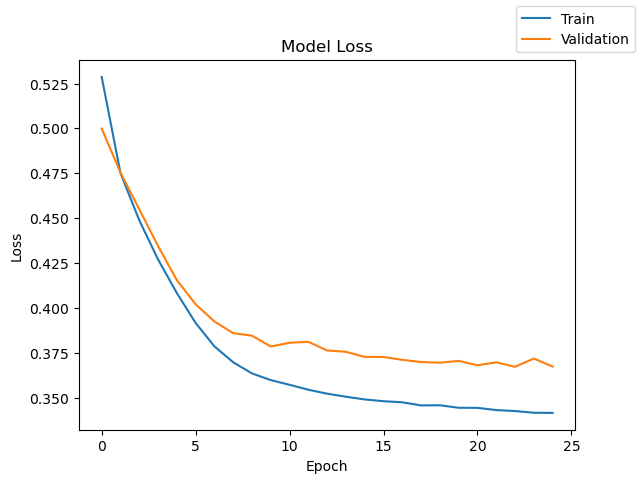

In [27]:
#Initializing the neural network
model = Sequential()
model.add(Dense(14,activation="relu",input_dim=X_train.shape[1],kernel_initializer ='he_normal'))
model.add(Dense(7,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.summary()


optimizer = tf.keras.optimizers.SGD(momentum = 0.9)    # defining SGD as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs, callbacks=[es])
end=time.time()

print("Time taken in seconds ",end-start)

plot(history,'loss')


In [28]:
# Performance check
model4_train_performance = model_performance_classification(model,X_train,y_train)
print(model4_train_performance)

model4_valid_performance = model_performance_classification(model,X_valid,y_valid)
print(model4_valid_performance)


200/200 [==============================] - 0s 389us/step
   Accuracy    Recall  Precision  F1 Score
0  0.859375  0.859375   0.849735  0.845915
50/50 [==============================] - 0s 391us/step
   Accuracy   Recall  Precision  F1 Score
0   0.85375  0.85375   0.842541  0.840259



Introducing weight initalization to the existing model, increased recalls slightly with no significant improvement

The next model to be built, will have the optimizer changed to Adam + early stopping, to examine if this improves my recall on both training and validation sets.

Neural Network with Adam Optimizer + early stopping 

In [29]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                252       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 365 (1.43 KB)
Trainable params: 365 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/25
100/100 [==============================] - 0s 2ms/step - loss: 0.5505 - val_loss: 0.4846
Epoch 2/25
100/100 [==============================] - 0s 698us/step - loss: 0.4646 - val_loss: 0.4667
Epoch 3/25
100/100 [==============================] - 0s 701us/step - loss: 0.4449 - val_loss: 0.4505
Epoch 4/25
100/100 [==============================] - 0s 701us/step - loss: 0.4282 - val_loss: 0.4354
Epoch 5/25
100/100 [==============================] - 0s 698us/step - loss: 0.4142 - val_loss: 0.4226
Epoch 6/25
100/100 [==============================] - 0s 704us/step - loss: 0.4040 - val_loss: 0.4146
Epoch 7/25
100/100 [==============================] - 0s 688us/step - loss: 0.3960 - val_loss: 0.4061
Epoch 8/25
100/100 [==============================] - 0s 700us/step - loss: 0.3887 - val_loss: 0.4004
Epoch 9/25
100/100 [==============================] - 0s 694us/step - loss: 0.3829 - val_loss: 0.3953
Epoch 10/25
100/100 [==============================] - 0s 695us/step - loss: 0.3776 

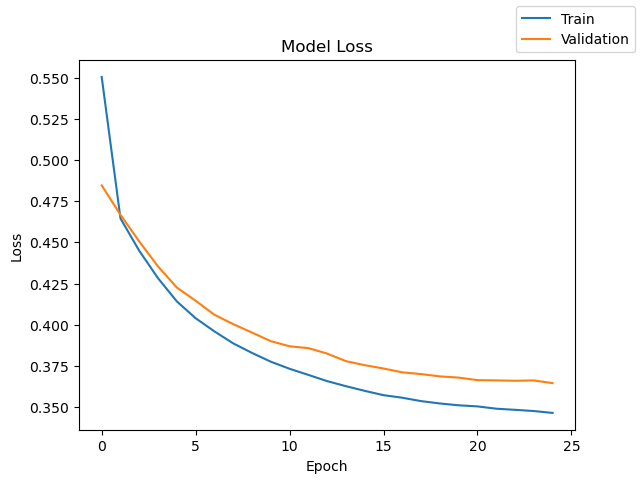

In [30]:
#Initializing the neural network
model = Sequential()
model.add(Dense(14,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(7,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.summary()


optimizer = tf.keras.optimizers.Adam()    
model.compile(loss='binary_crossentropy', optimizer=optimizer)

start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs, callbacks=[es])
end=time.time()

print("Time taken in seconds ",end-start)

plot(history,'loss')

In [31]:
# Performance check
model5_train_performance = model_performance_classification(model,X_train,y_train)
print(model5_train_performance)

model5_valid_performance = model_performance_classification(model,X_valid,y_valid)
print(model5_valid_performance)


200/200 [==============================] - 0s 411us/step
   Accuracy    Recall  Precision  F1 Score
0  0.855625  0.855625   0.844824  0.843692
50/50 [==============================] - 0s 384us/step
   Accuracy    Recall  Precision  F1 Score
0  0.850625  0.850625   0.838787  0.835191


There is a slight drop in recall for both training and validation sets, the adam optimizer is proving to be better. 
The next model will keep the adam initializer, early stopping and set learning rate to 0.001 and investigate whether performance is impacted. 

Neural Network with Adam Optimizer + early stopping + learning rate of 0.001


In [32]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                252       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 365 (1.43 KB)
Trainable params: 365 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/25
100/100 [==============================] - 1s 2ms/step - loss: 0.7340 - val_loss: 0.6645
Epoch 2/25
100/100 [==============================] - 0s 748us/step - loss: 0.6084 - val_loss: 0.5455
Epoch 3/25
100/100 [==============================] - 0s 747us/step - loss: 0.5028 - val_loss: 0.4794
Epoch 4/25
100/100 [==============================] - 0s 722us/step - loss: 0.4624 - val_loss: 0.4605
Epoch 5/25
100/100 [==============================] - 0s 701us/step - loss: 0.4406 - val_loss: 0.4430
Epoch 6/25
100/100 [==============================] - 0s 702us/step - loss: 0.4161 - val_loss: 0.4195
Epoch 7/25
100/100 [==============================] - 0s 700us/step - loss: 0.3908 - val_loss: 0.3993
Epoch 8/25
100/100 [==============================] - 0s 701us/step - loss: 0.3731 - val_loss: 0.3876
Epoch 9/25
100/100 [==============================] - 0s 698us/step - loss: 0.3641 - val_loss: 0.3831
Epoch 10/25
100/100 [==============================] - 0s 772us/step - loss: 0.3595 

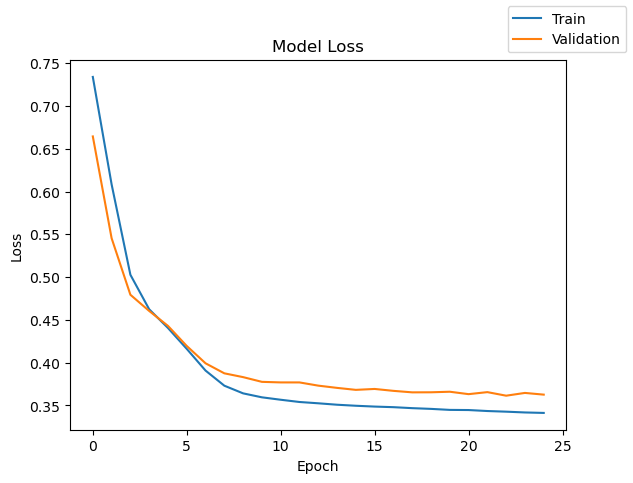

In [33]:
#Initializing the neural network
model = Sequential()
model.add(Dense(14,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(7,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.summary()


optimizer = tf.keras.optimizers.Adam(lr=0.001)    
model.compile(loss='binary_crossentropy', optimizer=optimizer)

start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs, callbacks=[es])
end=time.time()

print("Time taken in seconds ",end-start)

plot(history,'loss')

In [34]:
# Performance check
model6_train_performance = model_performance_classification(model,X_train,y_train)
print(model6_train_performance)

model6_valid_performance = model_performance_classification(model,X_valid,y_valid)
print(model6_valid_performance)


200/200 [==============================] - 0s 1ms/step
   Accuracy    Recall  Precision  F1 Score
0  0.860938  0.860938   0.851669  0.847766
50/50 [==============================] - 0s 448us/step
   Accuracy    Recall  Precision  F1 Score
0  0.855625  0.855625   0.845498  0.840105


The performance of both datasets have improved slightly. 
The next model to be built will introduce a fropout rate of 40% in the first hidden layer and 20% in the second hidden layer. 

Neural Network with Adam Optimizer + early stopping + learning rate + drop out


In [35]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                252       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 365 (1.43 KB)
Trainable params: 365 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/25
100/100 [==============================] - 1s 2ms/step - loss: 0.6798 - val_loss: 0.5252
Epoch 2/25
100/100 [==============================] - 0s 781us/step - loss: 0.5567 - val_loss: 0.4859
Epoch 3/25
100/100 [==============================] - 0s 787us/step - loss: 0.5310 - val_loss: 0.4753
Epoch 4/25
100/100 [==============================] - 0s 774us/step - loss: 0.5157 - val_loss: 0.4675
Epoch 5/25
100/100 [==============================] - 0s 716us/step - loss: 0.5056 - val_loss: 0.4585
Epoch 6/25
100/100 [==============================] - 0s 715us/step - loss: 0.4926 - val_loss: 0.4503
Epoch 7/25
100/100 [==============================] - 0s 727us/step - loss: 0.4853 - val_loss: 0.4427
Epoch 8/25
100/100 [==============================] - 0s 754us/step - loss: 0.4744 - val_loss: 0.4354
Epoch 9/25
100/100 [==============================] - 0s 739us/step - loss: 0.4624 - val_loss: 0.4288
Epoch 10/25
100/100 [==============================] - 0s 744us/step - loss: 0.4540 

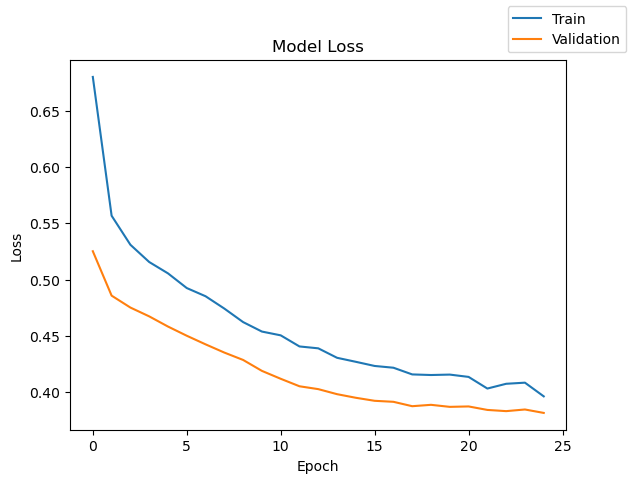

In [36]:
#Initializing the neural network
model = Sequential()
model.add(Dense(14,activation="relu",input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(Dense(7,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))

model.summary()


optimizer = tf.keras.optimizers.Adam(lr=0.001)    
model.compile(loss='binary_crossentropy', optimizer=optimizer)

start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs, callbacks=[es])
end=time.time()

print("Time taken in seconds ",end-start)

plot(history,'loss')

In [38]:
# Performance check
model7_train_performance = model_performance_classification(model,X_train,y_train)
print(model7_train_performance)

model7_valid_performance = model_performance_classification(model,X_valid,y_valid)
print(model7_valid_performance)


200/200 [==============================] - 0s 385us/step
   Accuracy    Recall  Precision  F1 Score
0  0.846875  0.846875   0.842314  0.819328
50/50 [==============================] - 0s 383us/step
   Accuracy   Recall  Precision  F1 Score
0   0.83625  0.83625   0.830412  0.801577


The performance on both the training and validation data set have decreased when drop out was implemented. 
The final model to be built will eliminate the dropout regularization technique and introduce batch normalization.

Neural Network with Adam Optimizer + early stopping + learning rate + batch normalization

In [39]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                252       
                                                                 
 batch_normalization (Batch  (None, 14)                56        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 batch_normalization_1 (Bat  (None, 7)                 28        
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 449 (1.75 KB)
Trainable params: 407 (1.59 

Epoch 1/25
100/100 [==============================] - 1s 2ms/step - loss: 0.7071 - val_loss: 0.5549
Epoch 2/25
100/100 [==============================] - 0s 914us/step - loss: 0.5454 - val_loss: 0.4968
Epoch 3/25
100/100 [==============================] - 0s 1ms/step - loss: 0.4725 - val_loss: 0.4609
Epoch 4/25
100/100 [==============================] - 0s 1ms/step - loss: 0.4363 - val_loss: 0.4393
Epoch 5/25
100/100 [==============================] - 0s 908us/step - loss: 0.4082 - val_loss: 0.4220
Epoch 6/25
100/100 [==============================] - 0s 976us/step - loss: 0.3915 - val_loss: 0.4088
Epoch 7/25
100/100 [==============================] - 0s 1ms/step - loss: 0.3814 - val_loss: 0.3987
Epoch 8/25
100/100 [==============================] - 0s 946us/step - loss: 0.3773 - val_loss: 0.3930
Epoch 9/25
100/100 [==============================] - 0s 883us/step - loss: 0.3714 - val_loss: 0.3882
Epoch 10/25
100/100 [==============================] - 0s 986us/step - loss: 0.3624 - val_

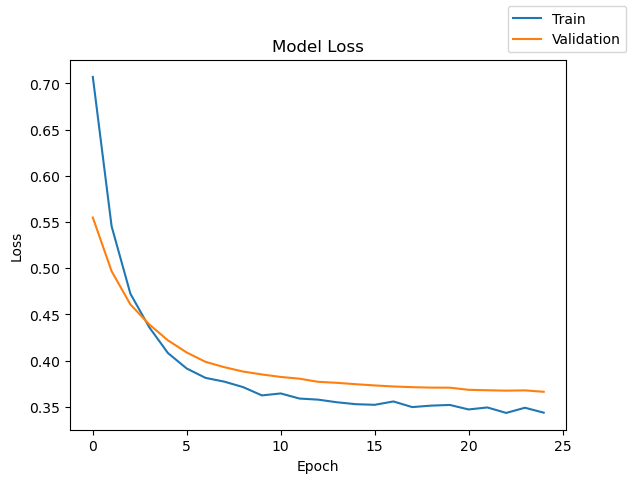

In [40]:
#Initializing the neural network
model = Sequential()
model.add(Dense(14,activation="relu",input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dense(7,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1,activation="sigmoid"))

model.summary()


optimizer = tf.keras.optimizers.Adam(lr=0.001)    
model.compile(loss='binary_crossentropy', optimizer=optimizer)

start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs, callbacks=[es])
end=time.time()

print("Time taken in seconds ",end-start)

plot(history,'loss')

In [41]:
# Performance check
model8_train_performance = model_performance_classification(model,X_train,y_train)
print(model8_train_performance)

model8_valid_performance = model_performance_classification(model,X_valid,y_valid)
print(model8_valid_performance)


200/200 [==============================] - 0s 453us/step
   Accuracy    Recall  Precision  F1 Score
0  0.863281  0.863281   0.854143  0.852205
50/50 [==============================] - 0s 423us/step
   Accuracy    Recall  Precision  F1 Score
0  0.848125  0.848125   0.835509  0.832745


The final model sees an improvement, in comparison with the previous model. 

Model comparison and selection

In [43]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model1_train_performance.T,
        model2_train_performance.T,
        model3_train_performance.T,
        model4_train_performance.T,
        model5_train_performance.T,
        model6_train_performance.T,
        model7_train_performance.T,
        model8_train_performance.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Neural Network (SGD, No Regularization)",
    "Neural Network (SGD, Momentum)",
    "Neural Network (SGD, Momentum, Early stopping)",
    "Neural Network (SGD, Momentum, Early stopping, Weight initialization)",
    "Neural Network (Adam, Early stopping)",
    "Neural Network (Adam, Early stopping,learning rate)",
    "Neural Network (Adam, Early stopping,learning rate,dropout)",
    "Neural Network (Adam, Early stopping,learning rate,batch normalization)"
]

print(models_train_comp_df)



           Neural Network (SGD, No Regularization)  \
Accuracy                                  0.800781   
Recall                                    0.800781   
Precision                                 0.840650   
F1 Score                                  0.716581   

           Neural Network (SGD, Momentum)  \
Accuracy                         0.858437   
Recall                           0.858437   
Precision                        0.848256   
F1 Score                         0.846870   

           Neural Network (SGD, Momentum, Early stopping)  \
Accuracy                                         0.858125   
Recall                                           0.858125   
Precision                                        0.847875   
F1 Score                                         0.846532   

           Neural Network (SGD, Momentum, Early stopping, Weight initialization)  \
Accuracy                                            0.859375                       
Recall                       

In [44]:
# validation performance comparison

models_valid_comp_df = pd.concat(
    [
        model1_valid_performance.T,
        model2_valid_performance.T,
        model3_valid_performance.T,
        model4_valid_performance.T,
        model5_valid_performance.T,
        model6_valid_performance.T,
        model7_valid_performance.T,
        model8_valid_performance.T
    ],
    axis=1,
)
models_valid_comp_df.columns = [
    "Neural Network (SGD, No Regularization)",
    "Neural Network (SGD, Momentum)",
    "Neural Network (SGD, Momentum, Early stopping)",
    "Neural Network (SGD, Momentum, Early stopping, Weight initialization)",
    "Neural Network (Adam, Early stopping)",
    "Neural Network (Adam, Early stopping,learning rate)",
    "Neural Network (Adam, Early stopping,learning rate,dropout)",
    "Neural Network (Adam, Early stopping,learning rate,batch normalization)"
]

print(models_valid_comp_df)


           Neural Network (SGD, No Regularization)  \
Accuracy                                  0.800625   
Recall                                    0.800625   
Precision                                 0.840550   
F1 Score                                  0.716220   

           Neural Network (SGD, Momentum)  \
Accuracy                         0.852500   
Recall                           0.852500   
Precision                        0.840960   
F1 Score                         0.839182   

           Neural Network (SGD, Momentum, Early stopping)  \
Accuracy                                         0.853750   
Recall                                           0.853750   
Precision                                        0.842612   
F1 Score                                         0.839679   

           Neural Network (SGD, Momentum, Early stopping, Weight initialization)  \
Accuracy                                            0.853750                       
Recall                       

In [45]:
models_train_comp_df.loc["Recall"] - models_valid_comp_df.loc["Recall"]

Neural Network (SGD, No Regularization)                                    0.000156
Neural Network (SGD, Momentum)                                             0.005937
Neural Network (SGD, Momentum, Early stopping)                             0.004375
Neural Network (SGD, Momentum, Early stopping, Weight initialization)      0.005625
Neural Network (Adam, Early stopping)                                      0.005000
Neural Network (Adam, Early stopping,learning rate)                        0.005313
Neural Network (Adam, Early stopping,learning rate,dropout)                0.010625
Neural Network (Adam, Early stopping,learning rate,batch normalization)    0.015156
Name: Recall, dtype: float64

Final Model: Neural Network (SGD, Momentum, Early stopping, Weight initialization) 
Reasoning:


Best recall score on the training set (~0.86), indicating strong performance in learning from the training data.
Best recall score on the validation set (~0.85), demonstrating good performance in generalizing to unseen data.


When considering validation scores only, Model 3 (Neural Network (SGD, Momentum, Early stopping)) and 4 (Neural Network (SGD, Momentum, Early stopping, Weight initialization)) produce the same scores, but I settled on model 4 because it has a slightly higher score on the training dataset, and has a regulation (weight initialization) introduced that can prevent overfitting of data in the real world case. It suggests its effectiveness in real-world applications and new data scenarios.

Final model with chosen model and testin using testing data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                252       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 365 (1.43 KB)
Trainable params: 365 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/25
100/100 [==============================] - 0s 2ms/step - loss: 0.5363 - val_loss: 0.5023
Epoch 2/25
100/100 [==============================] - 0s 691us/step - loss: 0.4817 - val_loss: 0.4839
Epoch 3/25
100/100 [==============================] - 0s 707us/step - loss: 0.4578 - val_loss: 0.4656
Epoch 4/25
100/100 [==============================] - 0s 741us/step - loss: 0.4346 - val_loss: 0.4475
Epoch 5/25
100/100 [==============================] - 0s 664us/step - loss: 0.4154 - val_loss: 0.4305
Epoch 6/25
100/100 [==============================] - 0s 689us/step - loss: 0.3986 - val_loss: 0.4163
Epoch 7/25
100/100 [==============================] - 0s 691us/step - loss: 0.3847 - val_loss: 0.4012
Epoch 8/25
100/100 [==============================] - 0s 685us/step - loss: 0.3745 - val_loss: 0.3894
Epoch 9/25
100/100 [==============================] - 0s 690us/step - loss: 0.3666 - val_loss: 0.3939
Epoch 10/25
100/100 [==============================] - 0s 667us/step - loss: 0.3626 

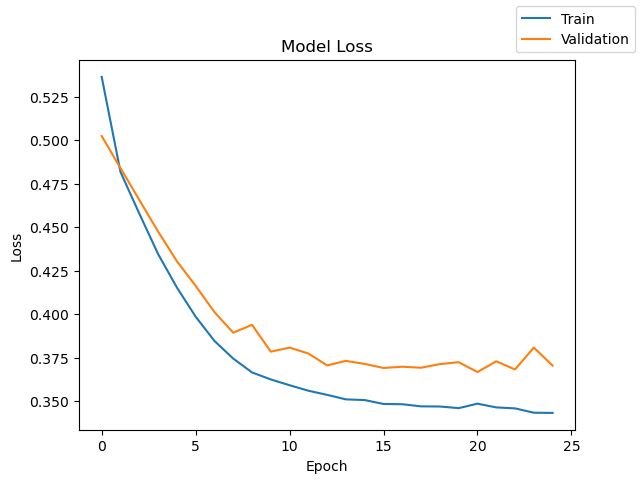

In [46]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

#Initializing the neural network
model = Sequential()
model.add(Dense(14,activation="relu",input_dim=X_train.shape[1],kernel_initializer ='he_normal'))
model.add(Dense(7,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.summary()


optimizer = tf.keras.optimizers.SGD(momentum = 0.9)    # defining SGD as the optimizer to be used
model.compile(loss='binary_crossentropy', optimizer=optimizer)

start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid) , batch_size=batch_size, epochs=epochs, callbacks=[es])
end=time.time()

print("Time taken in seconds ",end-start)

plot(history,'loss')

In [47]:
final_model_train_performance = model_performance_classification(model,X_train,y_train)
print(final_model_train_performance)


final_model_test_performance = model_performance_classification(model,X_test,y_test)
print(final_model_test_performance)

200/200 [==============================] - 0s 390us/step
   Accuracy    Recall  Precision  F1 Score
0  0.858281  0.858281   0.848287  0.848588
63/63 [==============================] - 0s 477us/step
   Accuracy  Recall  Precision  F1 Score
0     0.856   0.856    0.84524  0.843858
